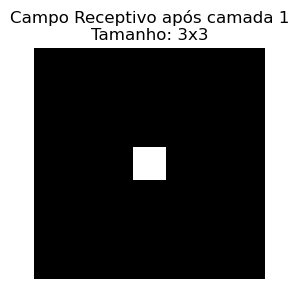

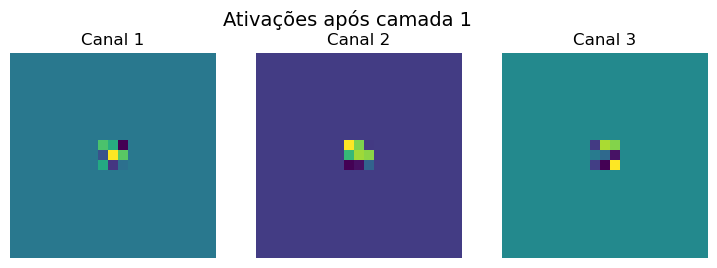

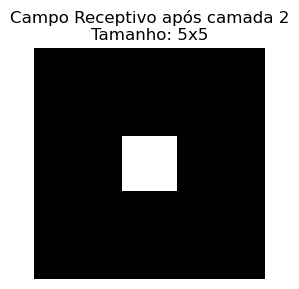

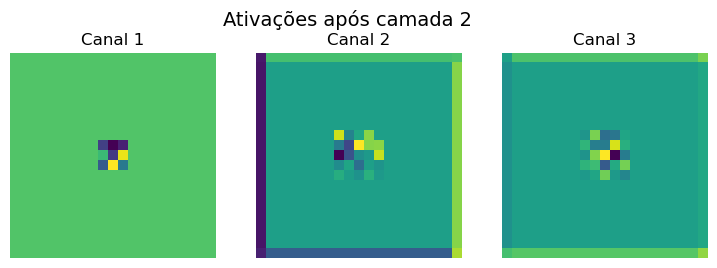

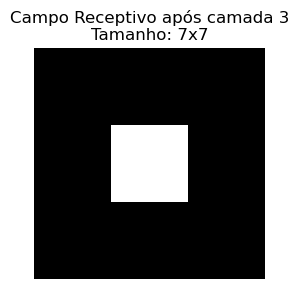

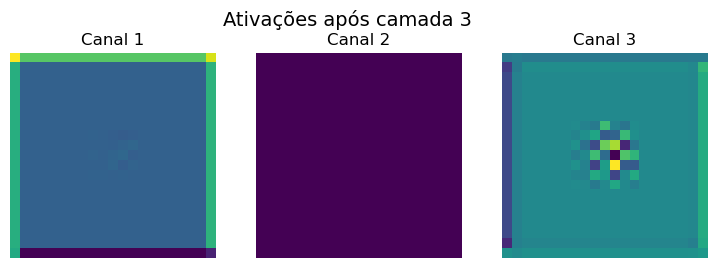

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as T

# === Funções auxiliares ===

def calc_receptive_fields(kernel_sizes, strides, paddings):
    rf = 1
    jump = 1
    start = 0.5
    receptive_fields = []

    for k, s, p in zip(kernel_sizes, strides, paddings):
        start = start + ((k - 1) / 2 - p) * jump
        rf = rf + (k - 1) * jump
        jump *= s
        receptive_fields.append((rf, start))

    return receptive_fields

def plot_receptive_field(input_size, rf, layer_idx):
    image = np.zeros((input_size, input_size))
    center = input_size // 2
    half_rf = int(rf // 2)

    image[center - half_rf:center + half_rf + 1, center - half_rf:center + half_rf + 1] = 1

    plt.figure(figsize=(3, 3))
    plt.title(f'Campo Receptivo após camada {layer_idx + 1}\nTamanho: {int(rf)}x{int(rf)}')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def plot_activations(activation, layer_idx):
    num_channels = activation.shape[1]
    fig, axs = plt.subplots(1, num_channels, figsize=(3 * num_channels, 3))
    fig.suptitle(f'Ativações após camada {layer_idx + 1}', fontsize=14)

    for i in range(num_channels):
        axs[i].imshow(activation[0, i].detach().cpu().numpy(), cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f'Canal {i+1}')

    plt.show()




## Entrada

In [ ]:
# === Entrada: carregue uma imagem de 32x32 (ou será usada uma padrão) ===

# Caminho para a imagem
image_path = '/home/gabriel/fingerprint-enhancement/notebooks/tree.png'  # Substitua por seu caminho

try:
    img = Image.open(image_path).convert('RGB')
    print(f"Imagem carregada: {image_path}")
except:
    # Gera uma imagem de exemplo (RGB com ponto branco no centro)
    img = np.zeros((32, 32, 3), dtype=np.uint8)
    img[16, 16] = [255, 255, 255]
    img = Image.fromarray(img)
    print("Imagem gerada com ponto branco no centro.")

# Transforma em tensor
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor()
])
x = transform(img).unsqueeze(0)  # [1, 3, 32, 32]

## Executa e VIsualiza

In [ ]:
# === Define a sequência de DWConvs ===

input_size = 32
kernel_sizes = [3, 3, 3]
strides = [1, 1, 1]
paddings = [1, 1, 1]
rfs = calc_receptive_fields(kernel_sizes, strides, paddings)

layers = nn.ModuleList([
    nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, groups=3),
    nn.ReLU(),
    nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, groups=3),
    nn.ReLU(),
    nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, groups=3),
    nn.ReLU()
])

# === Executa e visualiza ===

y = x.clone()
layer_counter = 0
rf_counter = 0

for layer in layers:
    y = layer(y)

    if isinstance(layer, nn.Conv2d):
        plot_receptive_field(input_size, rfs[rf_counter][0], rf_counter)
        plot_activations(y, rf_counter)
        rf_counter += 1
